# Pytorch - Generative Adversarial Network(GAN)

<font size=3><br>
前言廢話免了，會進來看文章內容的只有四種人 <br>
    1. 只想知道皮毛，GAN在幹什麼的 <br>
    2. 想知道細節怎麼把GAN訓練起來 <br>
    3. 收藏在我的最愛或是書籤當作有看過了 <br>
    4. 上課上到一定要點點進來。 <br>

GAN屬於unsupervised learning。 <br><br>
>白話一點，GAN是用來生成資料。<br>
    
>講難聽一點，GAN被廣泛用來造假的。(但也有正向的)<br>
    
</font>

<font size=3>最近比較知名的影像轉換，</font>

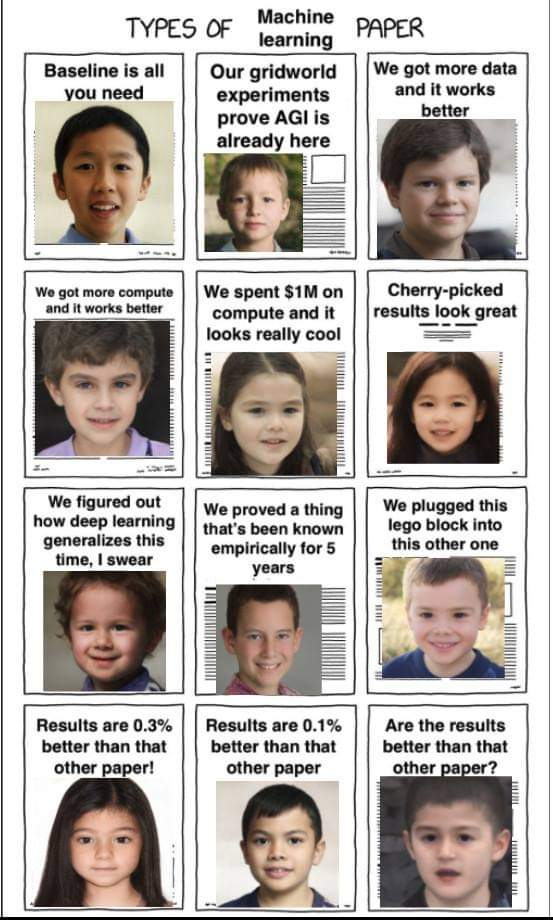

(source: https://www.reddit.com/r/MachineLearning/comments/o843t5/d_types_of_machine_learning_papers/)


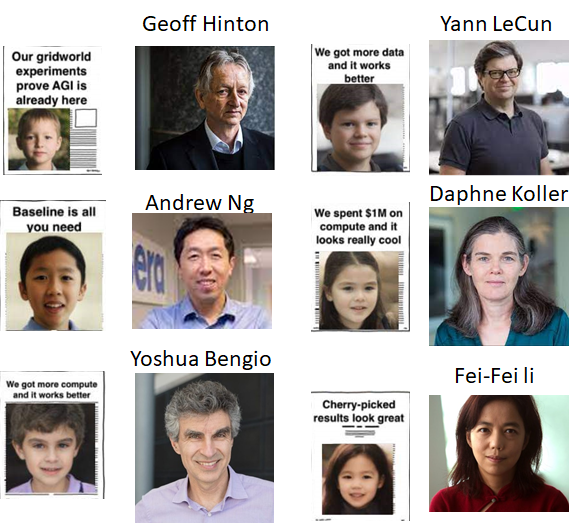

下面的網址有用StyleGAN: 可以讓人變年輕微笑的範例。
https://www.reddit.com/r/MachineLearning/comments/o6wggh/r_finally_actual_real_images_editing_using/

<font size=4> 讓照片活起來，點一下可以看影片 <br> </font>
    
    
<a href="https://i.imgur.com/i284hKw.mp4" target="_blank"> 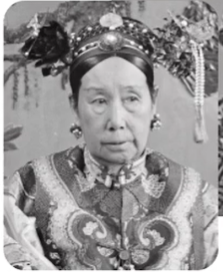

-------------------
<font size=4>
GAN 生成對抗網路:顧名思義，就是有兩個網路架構，分別為「生成」(Generator)和「對抗」(Discriminator) <br> <br>
GAN的概念很簡單，我們可以用一部老電影來描述(中文:神鬼交鋒，英文: Catch me if you can，英文比較有感): <br>
        
   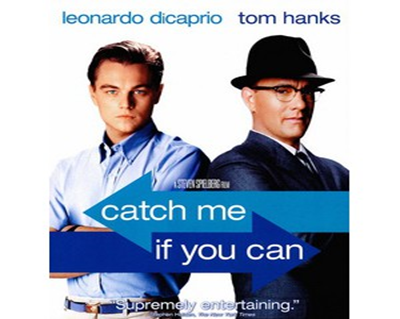 
    
一個造假者(李奧納多)和一個專家(湯姆漢克)，造假者需要做假的東西(假支票)出來，讓專家去判斷真偽，透過專家的判斷造假者在不斷的增進自己的造假技術，直到專家無法有效的判斷真偽。 <br>

整個GAN運作的核心概念如下，李奧納多就是「生成器(Generator)」，湯姆漢克就是「對抗: 辨別器(Discriminator)」: <br>
    
    
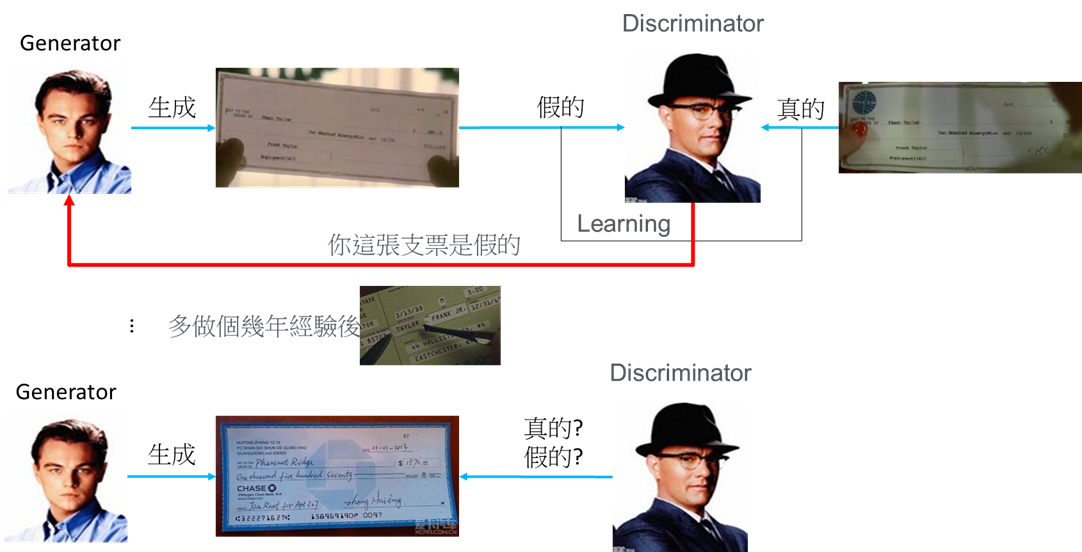
    


-------------
<font size=4> 花樣看完了 <br>
    實際上我們將GAN化成簡圖，如下
    
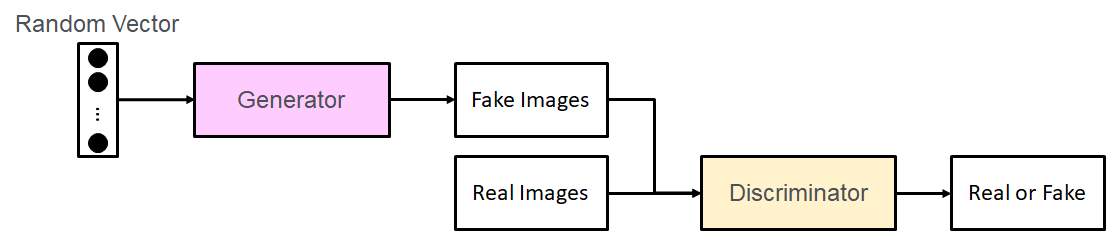    
    
<br>**Generator (G) 和 Discriminator (D)**<br><br>
>- D要判斷「真」還是「假」
>- G生成的資料要呼嚨D。<br><br>
    
從Random Vector(z，可以為均勻分布或是常態分布)丟入G生成出圖片，所以目的就是希望使得G(z)的機率分布接近D的機率分布。<br><br>

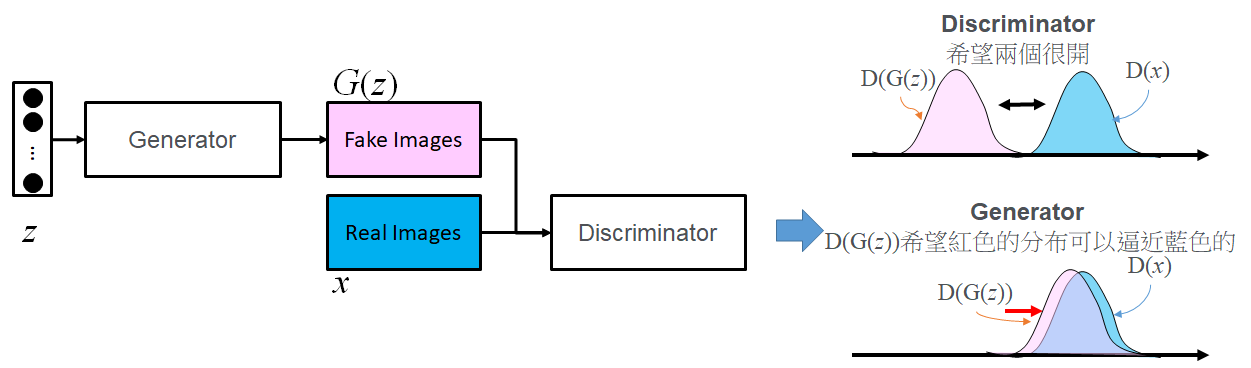

<font size=4 color='red'> Discriminator: </font>
<font size=4> 希望D(x)真實資料被判給真實的機率期望值最大(接近1) </font>
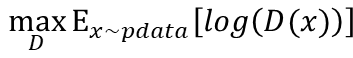

<font size=4 color='red'> Discriminator: </font>
<font size=4> 希望D(G(z))假資料被判給真實的機率期望值最小(接近0)</font>
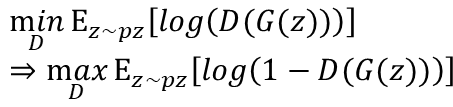

<font size=4 color='red'> Generator-> Discriminator: </font>
<font size=4> 因為要乎巄D，所以在Generator階段，希望D(G(z))假資料被判給真實的機率期望值最大(接近1)</font>
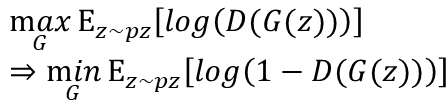

<font size=4 color='red'> **Objective Function of GAN:**</font>
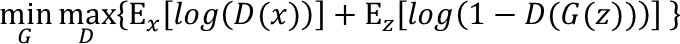

<font size=4> 看到這邊應該很有感才對，不管是在公式或是算法上 <br> <br>
    
實際上GAN的坑很多，光是Generator和Discriminator怎麼設計就是個坑了。<br> <br>
1. 後面範例以DCGAN的模型要設計過Generator才有辦法Upsample到MNIST的大小(28*28)。<br> <br>
2. Generator參數變化不要一次更新太大，通常可以更新幾次D後再更新G。 (MNIST範例很簡單，所以可以不用)<br> <br>
3. Learning rate不要設定太大。 如果大家有看過其他人範例大部分都設定為0.0002，其實這樣的設定有文獻出處[Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434) <br> <br> 
    
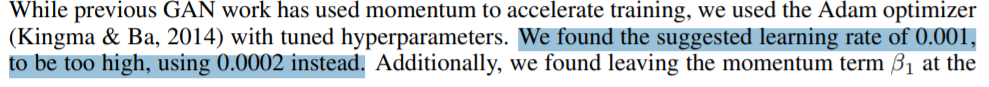

</font>

# Pytorch手把手進行DCGAN實作，以MNIST資料庫為例

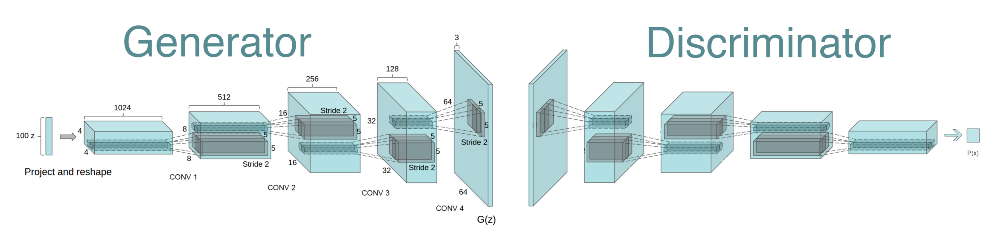


In [7]:
# -*- coding: utf-8 -*-
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import PIL.Image as Image


In C:\Users\user\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\user\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\user\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\user\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\user\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle

<font size=4>
    
**Generator** <br><br>
因為我的random vector(z)是採用 latents x 1 x 1 (latents代表z的維度數) <br><br>
DCGAN是採用ConvTranspose2d進行上採樣的進行，也就是讓圖變大張。 <br><br>
MNIST圖片為28 x 28，一般上採樣通常是固定放大1倍。 <br><br>

1 x 1 → 上採樣 → 2 x 2 → 上採樣 → 4 x 4 → 上採樣 → 8 x 8 → 上採樣 → 16 x 16 → 上採樣 → 32 x 32<br><br>
   
所以不會變成28 x 28。<br><br>
    
所以我利用ConvTranspose2d的stride和pad的設計，讓上採樣可以非1倍放大，細節請看程式碼，我每一層輸出的大小有寫在備註。<br>
1 x 1 → ConvTranspose2d → 2 x 2 → ConvTranspose2d → 3 x 3 → ConvTranspose2d → 6 x 6 → ConvTranspose2d → 7 x 7 → ConvTranspose2d → 14 x 14 → ConvTranspose2d → 28 x 28 <br><br>
   

In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
        
class CBR(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(CBR, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )
class CBLR(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(CBLR, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )
class TCBR(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=4, stride=2, padding=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(TCBR, self).__init__(
            nn.ConvTranspose2d(in_planes, out_planes, kernel_size, stride, padding, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )                    
                         
                         

class Generator(nn.Module):
    def __init__(self, latents):
        super(Generator, self).__init__()
        
        self.layer1= nn.Sequential(
            # input is random_Z,  state size. latents x 1 x 1 
            # going into a convolution
            TCBR(latents, 256, 4, 2, 1),  # state size. 256 x 2 x 2
            CBR(256, 128, 3, 1)
        )
        
        self.layer2= nn.Sequential(
            TCBR(128, 256, 4, 1, 0), # state size. 256 x 3 x 3
            TCBR(256, 256, 4, 2, 1), # state size. 256 x 6 x 6
            
        )
        self.layer3= nn.Sequential(
            TCBR(256, 128, 4, 1, 0), # state size. 256 x 7 x 7
            TCBR(128, 128, 4, 2, 1),  # state size. 256 x 14 x 14
            CBR(128, 128, 3, 1)
            # state size. 256 x 6 x 6

        )
        self.layer4= nn.Sequential(
            TCBR(128, 64, 4, 2, 1), # state size. 64 x 28 x 28
            CBR(64, 64, 3, 1),
            CBR(64, 64, 3, 1),
            nn.Conv2d(64, 1, 3, 1, 1), # state size. 1 x 28 x 28
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x
    

class Discriminator(nn.Module):
    def __init__(self,):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            CBLR(1, 32, 3, 2), # b*32*14*14
            CBLR(32, 64, 3, 1), # b*64*14*14
            CBLR(64, 128, 3, 2), # b*128*7*7
            CBLR(128, 128, 3, 2), # b*32*3*3
            CBLR(128, 64, 3, 2), # b*32*1*1
        )        
        self.fc = nn.Linear(64,2)

    def forward(self, x):
        x = self.conv(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        ft = x
        output = self.fc(x)
        return output

In [3]:
# from torchvision.utils import save_image

flag_gpu = 1
# Number of workers for dataloader
workers = 0
# Batch size during training
batch_size = 100
# Number of training epochs
epochs = 20
# Learning rate for optimizers
lr = 0.0002

# GPU
device = 'cuda:0' if (torch.cuda.is_available() & flag_gpu) else 'cpu'
print('GPU State:', device)
# Model
latent_dim = 10
G = Generator(latents=latent_dim).to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)

# Settings
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


g_scheduler = torch.optim.lr_scheduler.StepLR(g_optimizer, step_size=5, gamma=0.5)
d_scheduler = torch.optim.lr_scheduler.StepLR(d_optimizer, step_size=5, gamma=0.5)

# Load data
train_set = datasets.MNIST('./dataset', train=True, download=False, transform=transforms.ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=workers)

GPU State: cuda:0


<font size=4> Generator的更新</font>
    
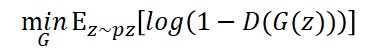

<font size=4> Discriminator的更新</font>
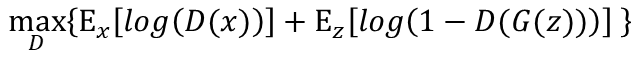

[Epoch: 1/20] D_loss: 0.373 G_loss: 1.240
Generated images for epoch: 1
[Epoch: 2/20] D_loss: 0.157 G_loss: 2.229
Generated images for epoch: 2
[Epoch: 3/20] D_loss: 0.145 G_loss: 2.603
Generated images for epoch: 3
[Epoch: 4/20] D_loss: 0.354 G_loss: 1.390
Generated images for epoch: 4
[Epoch: 5/20] D_loss: 0.447 G_loss: 1.162
Generated images for epoch: 5
[Epoch: 6/20] D_loss: 0.472 G_loss: 1.064
Generated images for epoch: 6
[Epoch: 7/20] D_loss: 0.473 G_loss: 1.062
Generated images for epoch: 7
[Epoch: 8/20] D_loss: 0.444 G_loss: 1.131
Generated images for epoch: 8
[Epoch: 9/20] D_loss: 0.437 G_loss: 1.152
Generated images for epoch: 9
[Epoch: 10/20] D_loss: 0.460 G_loss: 1.115
Generated images for epoch: 10
[Epoch: 11/20] D_loss: 0.535 G_loss: 0.956
Generated images for epoch: 11
[Epoch: 12/20] D_loss: 0.491 G_loss: 1.026
Generated images for epoch: 12
[Epoch: 13/20] D_loss: 0.509 G_loss: 0.994
Generated images for epoch: 13
[Epoch: 14/20] D_loss: 0.502 G_loss: 1.013
Generated ima

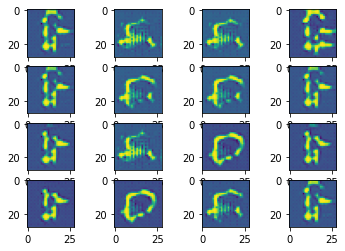

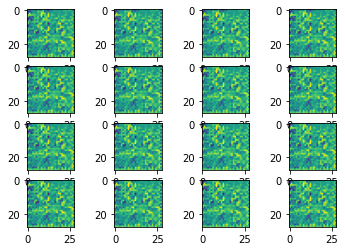

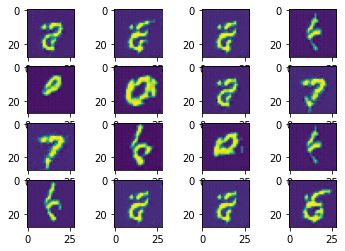

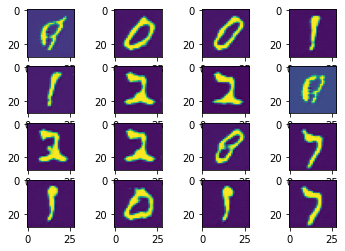

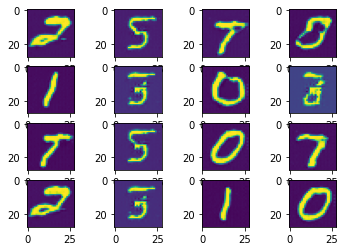

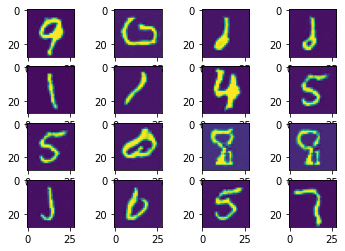

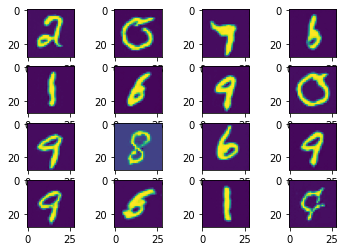

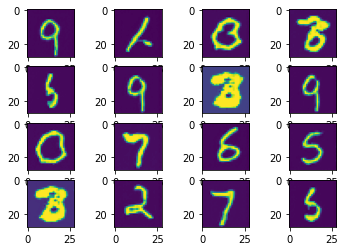

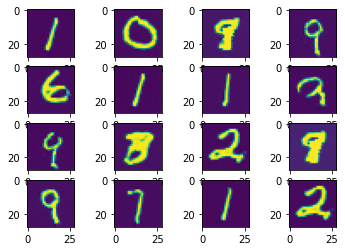

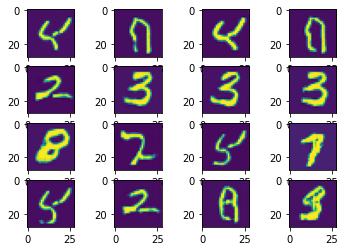

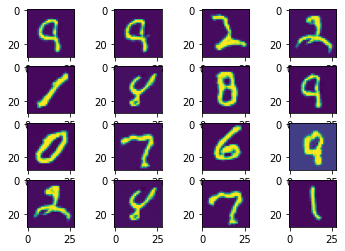

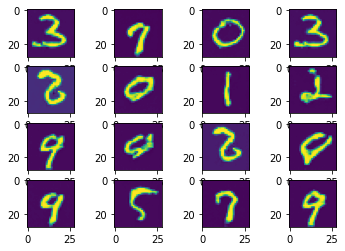

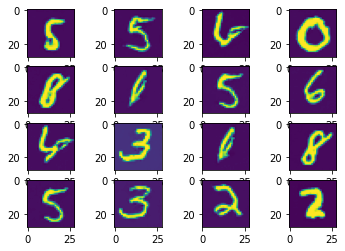

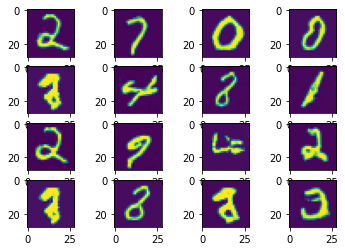

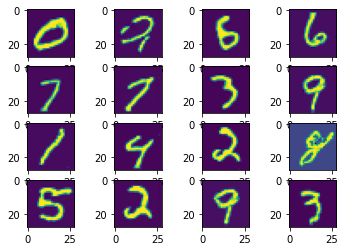

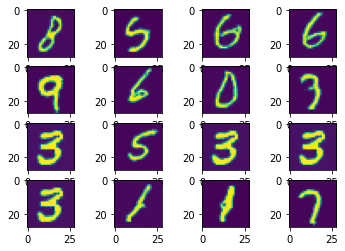

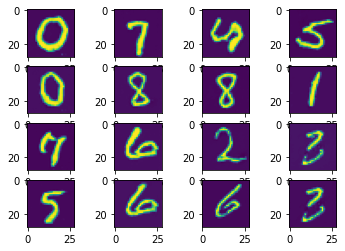

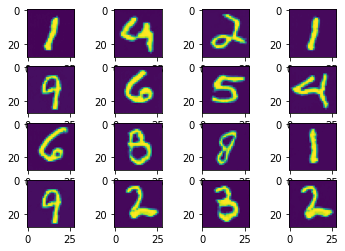

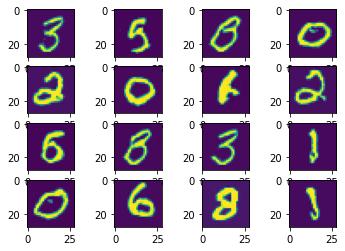

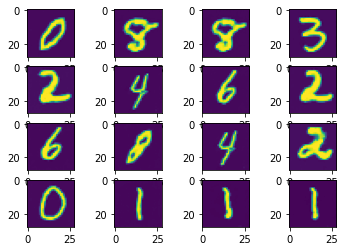

In [4]:
def show_images(images, epoch):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    plt.figure()
    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28))
    plt.savefig("Generator_epoch_{}.png".format(epoch))
# Train
adversarial_loss = torch.nn.CrossEntropyLoss().to(device)
# adversarial_loss = torch.nn.BCELoss().to(device)

G.train()
D.train()
loss_g, loss_d = [],[]
start_time= time.time()
for epoch in range(epochs):
    epoch += 1
    total_loss_g,total_loss_d=0,0
    count_d=0
    for i_iter, (images, label) in enumerate(train_loader):
        i_iter += 1

        # -----------------
        #  Train Generator
        # -----------------
        g_optimizer.zero_grad()
        # Sample noise as generator input
        noise = torch.randn(images.shape[0], latent_dim, 1, 1)
        noise = noise.to(device)
        
        # 因為Generator希望生成出來的圖片跟真的一樣，所以fake_label標註用 1
        fake_label = torch.ones(images.shape[0], dtype=torch.long).to(device) # notice: label = 1


        # Generate a batch of images
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        
        # Loss measures generator's ability to fool the discriminator
        loss_g_value = adversarial_loss(fake_outputs, fake_label)
        loss_g_value.backward()
        g_optimizer.step()
        total_loss_g+=loss_g_value
        loss_g.append(loss_g_value) 
        

        # ---------------------
        #  Train Discriminator
        # ---------------------
        # Zero the parameter gradients
        d_optimizer.zero_grad()
        # Measure discriminator's ability to classify real from generated samples
        # 因為Discriminator希望判斷哪些是真的那些是生成的，所以real_label資料標註用 1，fake_label標註用0。
        real_inputs = images.to(device) 
        real_label = torch.ones(real_inputs.shape[0], dtype=torch.long).to(device)
        fake_label = torch.zeros(fake_inputs.shape[0], dtype=torch.long).to(device)
#       learning by Discriminator
        real_loss = adversarial_loss(D(real_inputs),real_label)
        fake_loss = adversarial_loss(D(fake_inputs.detach()),fake_label)

        loss_d_value = (real_loss + fake_loss) / 2
        loss_d_value.backward()
        d_optimizer.step()
        total_loss_d+=loss_d_value
        loss_d.append(loss_d_value)
        
       
    total_loss_g/=len(train_loader)
    total_loss_d/=len(train_loader)
                
    g_scheduler.step()
    d_scheduler.step()
    
    
     

    print('[Epoch: {}/{}] D_loss: {:.3f} G_loss: {:.3f}'.format(epoch, epochs, total_loss_d.item(), total_loss_g.item()))
    if epoch % 1 == 0:
        print('Generated images for epoch: {}'.format(epoch))
        imgs_numpy = fake_inputs.data.cpu().numpy()
        show_images(imgs_numpy[:16],epoch)
#         plt.show()

torch.save(G, 'DCGAN_Generator.pth')
torch.save(D, 'DCGAN_Discriminator.pth')
print('Model saved.')

print('Training Finished.')
print('Cost Time: {}s'.format(time.time()-start_time))

In [5]:
plt.plot(loss_g)
plt.plot(loss_d,'r')
plt.legend(['G','D'])
plt.show()


----------------
## Generator測試


cuda:0


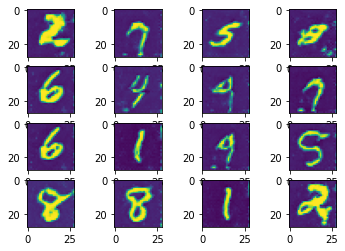

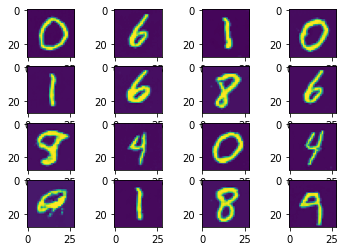

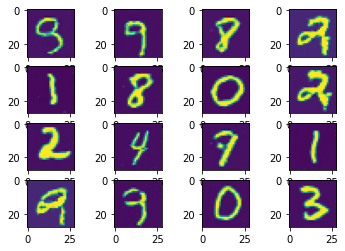

In [15]:
import torch
def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    plt.figure()
    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28))
    plt.show()

flag_gpu = 1
device = 'cuda:0' if (torch.cuda.is_available() & flag_gpu) else 'cpu'
print(device)

G = torch.load('DCGAN_Generator.pth', map_location=device)
  
latent_dim = 10

## Exp:1
noise = torch.randn(20, latent_dim, 1, 1)
noise = noise.to(device)
        
# Generate a batch of images
fake_inputs = G(noise)
        
imgs_numpy = fake_inputs.data.cpu().numpy()
show_images(imgs_numpy[:16])

## Exp:2
noise = torch.randn(20, latent_dim, 1, 1) *-10000
noise = noise.to(device)
        
# Generate a batch of images
fake_inputs = G(noise)
        
imgs_numpy = fake_inputs.data.cpu().numpy()
show_images(imgs_numpy[:16])


## Exp:3
noise = torch.randn(20, latent_dim, 1, 1) *50000
noise = noise.to(device)
        
# Generate a batch of images
fake_inputs = G(noise)
        
imgs_numpy = fake_inputs.data.cpu().numpy()
show_images(imgs_numpy[:16])